# Principal Component Analysis

Data Souces can have many dimensions. To get a sense of the relative variances, Principal Component Analysis (PCA) can be effective. PCA is an orthogonal transformation that converts a set of samples into a different set of dimensions that are not correlated (i.e. orthogonal). The dimensions are determined by greatest variance and are orthogonal. PCA is useful when the dimensions of data are not well suited but there is an apparent relationship between them. For that reason, it can be helpful in reducing the number of dimensions.

The 'principal components' or components of Principal Component Analysis (PCA) the eigenvalues of the covariance matrix for a given dataset. The explained variance (eigenvectors) provide the weights for each feature (column) of that dataset, and relative variance of each component.


By the end of this file you should have seen simple examples of:  
1. Two dimensional PCA - explained variance and component vectors  
  a. Projection of data into the new basis determined by PCA  
  b. Recovery of original dataset from projected data
2. Four dimensional PCA with projection of the first two components
  


Further Reading:  
Section 7.3 Principal Component Analysis (PCA by the SVD), Introduction to Linear Algebra, Fifth Edition, 2016.  
 - http://math.mit.edu/~gs/linearalgebra/    

https://github.com/scikit-learn/scikit-learn/blob/a243d96336cb4f50ca3635b3062a273f3dc5183a/sklearn/utils/extmath.py#L482-L523

In [1]:
import numpy as np
from matplotlib import pyplot as plt
rand_seed = 1 # set the random number generator so results are repeatable

# 2-D example:
First, let's take a look at a 2 dimensional example, as it's easiest to visualize:

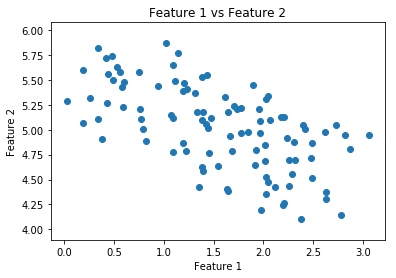

In [2]:
# Generate some 2D data:
x = np.linspace(0,1,100)
y1 = 2.2*x
y2 = 5 - x
dat = np.vstack([y1,y2]).T
np.random.seed(rand_seed)
dat_n = dat + np.random.rand(*dat.shape)*(np.array([1,1])) # add noise

# plot as scatter
plt.scatter(dat_n[:, 0], dat_n[:, 1])
plt.title('Feature 1 vs Feature 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.show()

### Find Covariance

Next we find the covariance, of the amount each feature varies with another:

$$ cov(x,y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i-\overline{x})(y_i - \overline{y})$$

We can do this for all features in a dataset, creating a n$x$n matrix representing how each feature co-varies with another:

$$ cov = \sum_{j=1}^{n}(x_j-\overline{x})(x_j - \overline{x})^T$$

Where: $\overline{x}$ is the expectation of x. If each value is equally weighted, then:  
$$ \overline{x} = \frac{1}{n}\sum_{j=1}^{n}x_j$$

Note that the data here is plotted in row format (list of rows) vs columnar format (list of columns). Our math is performed on a per sublist basis, so a transpose is necessary:

In [3]:
datc_n = dat_n.T

In [4]:
# The covariance matrix is the inner product of the mean-subtracted dataset with it's transpose:
datc_ms = (datc_n - datc_n.mean(axis=1)[:, np.newaxis]) # Mean subtract the data set:
dat_cov = datc_ms.dot(datc_ms.T)/(datc_n.shape[1]-1) 

print('Covariance matrix is:\n{}'.format(dat_cov))

Covariance matrix is:
[[ 0.543647   -0.18700339]
 [-0.18700339  0.17630051]]


In [5]:
# Similarly, we could use a built-in numpy package:
dat_cov2 = np.cov(datc_n)

# Are these the same (check if they are within floating point error)?
np.isclose(dat_cov, dat_cov2).all() 

True

## Perform an eigen decomposition 
**This will determine the direction (eigenvalues or explained variance) and set of vectors (eigenvectors or components) that satisfy the relation:**

$$ M\vec{\nu} = \lambda \vec{\nu}$$

Where in our case:   
- $M$ is a measure of the variance of our dataset (often covariance)
- $\vec{\nu}$ is a vector
- $\lambda$ is a scalar associated with vector $\vec{\nu}$

In words, eigenvector $\vec{\nu}$ of matrix $M$ is equal to the scalar eigenvalue $\lambda$ of $\vec{\nu}$

From the perspective of PCA, the eigenvectors are the directions in terms of the original features (components) and the eigenvalues are the magnitudes of each vector (explained variance).

Usually, software packages (i.e. numpy, matlab) determine eigenvectors such that the length of each is 1. While computation by hand doesn't necessarily always work out this way, the decomposition into unitary vectors makes a bit more sense: the eigenvalues are the length of the vectors, and the vectors provide direction.

**The eigenvalues are the explained variance, or relative 'importance' of the pca component, and the eigenvectors are the components, or relative weights of the original features within each explained vector.**

In [6]:
eig_vals, eig_vecs = np.linalg.eig(dat_cov)

print('Eigenvalues (explained variance):\n {}'.format(eig_vals))
print('Eigenvectors (components):\n {}'.format(eig_vecs))

Eigenvalues (explained variance):
 [0.62209229 0.09785522]
Eigenvectors (components):
 [[ 0.92215125  0.3868295 ]
 [-0.3868295   0.92215125]]


Singular value decomposition (SVD) is a more general approach than the eigen decomposition and frequently used on the back end of software computing PCA.

SVD is another matrix factorization like eigen decomposition, but has all kinds of uses including the pseudoinverse, least squares fitting of data, and determining the rank, range, and null space of a matrix.

$$X = U \Sigma V^T $$
where
$$ U^TU = I $$
and
$$ V^TV = I $$
where:
- $X$ is our centered (mean-subtracted) dataset
- $I$ is the identity matrix
- $T$ is the conjugate transpose


SVD can be used to determine the eigenvalues and eigenvectors:

In [7]:
dat_ms = dat_n - dat_n.mean(axis=0)
u,s,v = np.linalg.svd(dat_ms, full_matrices=False) # Note that we didn't use the row formatted data (sklearn svd_flip function expects columnar data)

# The explained variance is the square of the SVD singular matrix:
expl_var = (s ** 2) / (dat_n.shape[0] - 1)
print('Explained Variance:\n{}'.format(expl_var))

print('Components:\n {}'.format(v))

Explained Variance:
[0.62209229 0.09785522]
Components:
 [[ 0.92215125 -0.3868295 ]
 [ 0.3868295   0.92215125]]


SVD results in three vectors, so the signs can be different and still yield the same result. To standardize, scikit-learn has a function so the output sign is predictable.

The negative sign doesn't change the magnitude, only the direction. scikit-learn has a function to specify both the order and signs of our eigenvectors (termed 'components' in PCA).

In [8]:
def skl_svd_flip(u,v):
    # Set the signs deterministically - taken from the svd_flip function in sklearn:
    # sklearn.utils.extmath.svd_flip
    max_abs_cols = np.argmax(np.abs(u), axis=0)
    signs = np.sign(u[max_abs_cols, range(u.shape[1])])
    u *= signs
    v *= signs[:, np.newaxis]
    return u,v

# Fix the output sign:
u, components = skl_svd_flip(u, v)
print('Flipped eigenvectors are:\n {}'.format(components))

Flipped eigenvectors are:
 [[-0.92215125  0.3868295 ]
 [-0.3868295  -0.92215125]]


### Plot explained variance:

How much of each component is the total sum of variance? This is often used as a proxy for how much 'information' is contained in each componet. Keep in mind, variance results from both signal and noise.

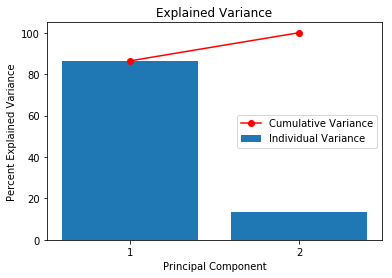

In [9]:
# Visualize explained variance:
tot = sum(expl_var)
var_exp = [(i / tot)*100 for i in sorted(expl_var, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

xlabels = ['{}'.format(x) for x in range(1, len(var_exp)+1)]

plt.bar(xlabels, var_exp, label='Individual Variance')
plt.plot(xlabels, cum_var_exp, label='Cumulative Variance', marker='o', color='red')

plt.ylabel('Percent Explained Variance')
plt.xlabel('Principal Component')
plt.title('Explained Variance')
plt.legend()

plt.show()

### Plot the values with new axes overlaid:

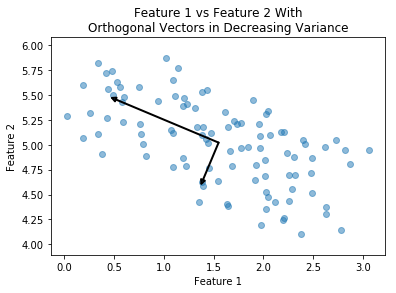

In [10]:
def draw_vector(head, tail, ax=None):
    ax = plt.gca()
    arrowprops=dict(arrowstyle='-|>',
                    linewidth=2,
                    shrinkA=0, 
                    shrinkB=0)
    ax.annotate('', tail, head, arrowprops=arrowprops)

# Plot data
plt.scatter(dat_n[:, 0], dat_n[:, 1], alpha=0.5)
for length, vector in zip(expl_var, components):
    v = vector*1.5*np.sqrt(length)
    draw_vector(dat_n.mean(axis=0), dat_n.mean(axis=0)+ v)

plt.title('Feature 1 vs Feature 2 With\nOrthogonal Vectors in Decreasing Variance')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal');

## Project data onto the component space

Project the original data points onto the dimensions defined by the component vectors (variance of the original dataset):

Projections are: 
$Z = X \vec{\nu}$  
where:  
$X$ is our dataset  
$\vec{\nu}$ is the eigen vectors (aka components or basis set)

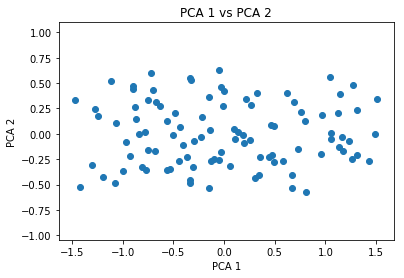

In [11]:
# Use the mean subtracted values
dat_proj = (dat_n - dat_n.mean(axis=0)).dot(components.T) # Use the transpose of the components - numpy is row formatted

# plot as scatter
plt.scatter(dat_proj[:, 0], dat_proj[:, 1])
plt.title('PCA 1 vs PCA 2')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.axis('equal')
plt.show()

## Recover the original dataset:

$$ M = Z \vec{\nu}^T$$
$$ or  $$
$$ M = M \vec{\nu}\vec{\nu}^T$$  

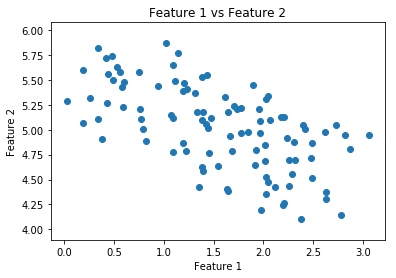

In [12]:
dat_n_recovered = dat_proj.dot(components) + dat_n.mean(axis=0)

plt.scatter(dat_n_recovered[:,0], dat_n_recovered[:,1])
plt.title('Feature 1 vs Feature 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.axis('equal')
plt.show()

In [13]:
# Did we recover our original dataset?
np.isclose(dat_n, dat_n_recovered).all() 

True

## Built-in functions:

Knowing what we know now, scikit-learn has a PCA class that reduces code greatly:

In [14]:
from sklearn.decomposition import PCA

# Perform PCA, obtain explained variance and basis components:
pca = PCA().fit(dat_n)
expl_var2 = pca.explained_variance_
components2 = pca.components_

# Project onto new basis:
dat_proj2 = pca.transform(dat_n)

# Apply data (usually transformed in some way) from the new axis back to the originial
dat_n_recovered2 = pca.inverse_transform(dat_proj2)

In [15]:
# Does the manual method match the built-in functions?
# np.isclose checks if they are within floating point error:
print(np.isclose(expl_var, expl_var2).all())
print(np.isclose(components, components2).all())
print(np.isclose(dat_proj, dat_proj2).all())
print(np.isclose(dat_n_recovered, dat_n_recovered2).all())

True
True
True
True


# 4-D example

Let's try it again with more dimensions to demonstrate dimensionality reduction:

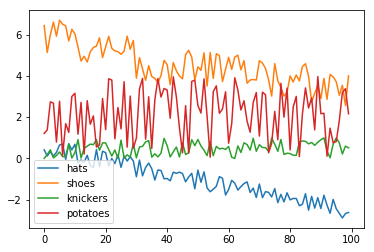

In [16]:
# Generate some 4D data:
x = np.linspace(0,1,100)
y1 = x*-3
y2 = 5/(1+x)
y3 = x*.003
y4 = x*0.0022

dat_4d = np.vstack([y1,y2,y3,y4]).T
np.random.seed(rand_seed)
dat_n_4d = dat_4d + np.random.rand(*dat_4d.shape)*(np.array([1,2,1,4])) # add noise

# Plot data:
plt.plot(dat_n_4d)
plt.legend(['hats','shoes','knickers','potatoes'])
plt.show()

Three of these components have nearly the same variance. While we can plot in 3d, it's easy to imagine a situation with 4 or more components each with high variance. How do we visualize them?

In [17]:
# Perform PCA, obtain explained variance and basis components:
from sklearn.decomposition import PCA
pca_4d = PCA().fit(dat_n_4d)
expl_var_4d = pca_4d.explained_variance_
components_4d = pca_4d.components_

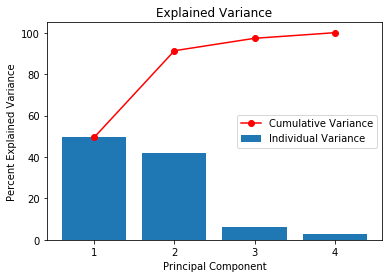

In [18]:
# Visualize explained variance:
tot = sum(expl_var_4d)
var_exp_4d = [(i / tot)*100 for i in sorted(expl_var_4d, reverse=True)]
cum_var_exp_4d = np.cumsum(var_exp_4d)

xlabels_4d = ['{}'.format(x) for x in range(1, len(var_exp_4d)+1)]

plt.bar(xlabels_4d, var_exp_4d, label='Individual Variance')
plt.plot(xlabels_4d, cum_var_exp_4d, label='Cumulative Variance', marker='o', color='red')

plt.ylabel('Percent Explained Variance')
plt.xlabel('Principal Component')
plt.title('Explained Variance')
plt.legend()
plt.show()

Components 3 and 4 don't have much variance. Let's view the first two and look for any structure. This way, we can view the dataset in a reduced dimensional subspace (selected according to variance).

Each component is a 4 component vector (4-d data). Simply repeat the projection from above, using only the first two:

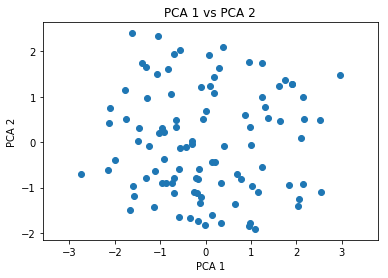

In [19]:
# Take the components of the first two vectors:
dat_n_4d_ms = dat_n_4d - dat_n_4d.mean(axis=0)
dat_proj2d = (dat_n_4d_ms).dot(components_4d[0:2,:].T)  # First two vectors:

plt.scatter(dat_proj2d[:,0], dat_proj2d[:,1])
plt.title('PCA 1 vs PCA 2')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.axis('equal')
plt.show()

Similarly, we could use the built-in function to plot the 2D projection, but we must specify the number of components during the PCA to do so (and thus couldn't plot explained variance for all dimensions). Also, only the highest variace dimensions are returned:

In [20]:
dat_proj2d2 = PCA(2).fit(dat_n_4d).transform(dat_n_4d)
print(np.isclose(dat_proj2d, dat_proj2d2).all())

True


# Correlation, covariance, and Standardized values

PCA can be peformed on covariance or correlation. Correlation is different because it is standardized between $ -1 < \text{corr} < 1 $. 

Correlation is useful where units are difficult to compare, i.e. kg vs miles. When using covariance, different units can yield different results, but with correlation, they are normalized. The correlation is:

$$ corr(x,y) =  \frac{1}{\sigma_x \sigma_y} \frac{1}{n-1}\sum_{i=1}^{n}(x_i-\overline{x})(y_i - \overline{y})$$
where:
$$ \sigma_x = \text{standard deviation of variable x} $$


or just:
$$ corr(x,y) =  \frac{1}{\sigma_x \sigma_y} cov(x,y) $$

The correlation and covariance matrices are scaled by 1/product of the standard deviations:
$$\frac{1}{\sigma_x \sigma_Y}$$   

Using just the covariances along the matrix diagonal, (and taking the square root) we obtain the standard deviations. 
We can use these to create a new matrix of $\frac{1}{\sigma_x \sigma_Y}$ and multiply by the covariance matrix element-wise to obtain the correlation matrix:

In [35]:
# Use the square root of the covariances along the diagonal to obtain the standard deviations:
dat_cov = np.cov(dat_n_4d.T)
stdevs = np.sqrt(np.diag(dat_cov)) 
# Then multiply such that the 1/product of the standard deviations
dat_corr = 1/stdevs[:,np.newaxis]* 1/stdevs[np.newaxis,:] * dat_cov

print('The Correlation matrix is:\n{}'.format(dat_corr))

The Correlation matrix is:
[[ 1.          0.78200483 -0.24018699 -0.01500673]
 [ 0.78200483  1.         -0.22381255 -0.04665663]
 [-0.24018699 -0.22381255  1.         -0.04921112]
 [-0.01500673 -0.04665663 -0.04921112  1.        ]]


In [36]:
# Via built-in functions:
dat_corr2 = np.corrcoef(dat_n_4d.T)
np.isclose(dat_corr, dat_corr2).all()

True

## Using StandardScaler:

Alternatively, instead of using the correlation matrix, one could use the standard scaler (center the data and scale by the standard devation per each feature), yielding a different but also scaled result.

In [30]:
# Scaled/Standardized values:
dat_n_s4d = (dat_n_4d - dat_n_4d.mean(axis=0))/(dat_n_4d.std(axis=0))

# Use sklearn:
from sklearn.preprocessing import StandardScaler
dat_n_s4d22 = StandardScaler().fit_transform(dat_n_4d)

# Are they the same?
np.isclose(dat_n_s4d, dat_n_s4d22).all()

True

The covariane of StandardScaled data is different from the correlation, which is scaled by the inverse product of the standard deviations. More information is lost; use with caution.

In [33]:
# The covariance of the standard scaled result is different than the correlation
dat_n_s_cov = np.cov(dat_n_s4d.T)
dat_n_corr = np.corrcoef(dat_n_4d.T)

np.isclose(dat_n_s_cov, dat_n_corr).all()

False